In [1]:
import time

import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
from treesampling import algorithms
from treesampling.utils.graphs import random_uniform_graph, random_tree_skewed_graph, tuttes_tot_weight, normalize_graph_weights, reset_adj_matrix, tree_to_newick, graph_weight
sns.set_style("white")

# Tree sampling analysis

For each graph size, generate a weight matrix which gives most of the probability mass to the arcs of one single tree. Then sample from the matrix a number of trees
and compute the (approximate) total weight using Tutte's determinant based method. Accumulate the probability mass explored with such samples and determine the residual
mass. Draw some additional samples without accumulating probability and test whether unseen trees are sampled with the same frequencies as the residual probability mass.

Later, make some plots to observe covering time and execution time for different sizes. 

In [16]:
def sampling_coverage_test(k_vals: list, sample_size: int = 2000, root: int = 0, skew_factor: int = 300, log_scale: bool = False, extra_draws: int = 0, verbose: bool = True):
    """
    Perform experiment for a number of different graph sizes
    :param k_vals: graph sizes (number of nodes)
    :param sample_size: size of sample (number of draws)
    :param root: label of node to be chosen as root
    :param skew_factor: a random tree is sampled, then weights of those edges compared to the rest is x:1 
    :param log_scale: whether to use log or non-log scale weigth matrix (and algorithm)
    :param extra_draws: number of additional draws which will be used to determine the rate of low prob events
        compared to the residual probability mass according to the determinant based normalization
    :param verbose: prints some stats while running
    :return: pandas dataframe with a record for each unseen tree
    """
    records = []
    
    for n_nodes in k_vals:
        graph, target_tree = random_tree_skewed_graph(n_nodes, skew_factor)
        target_tree_nwk = tree_to_newick(target_tree)
        mst_nwk = tree_to_newick(nx.maximum_spanning_arborescence(graph))
        norm_graph = normalize_graph_weights(graph, rowwise=False)
        tot_weight = tuttes_tot_weight(norm_graph, root)
        log_graph = reset_adj_matrix(graph, np.log(nx.to_numpy_array(graph)))
        
        for e in target_tree.edges():
            target_tree.edges[e]['weight'] = norm_graph.edges()[e]['weight']
        target_tree_weight = np.exp(graph_weight(target_tree, log_probs=True)) if log_scale else graph_weight(target_tree)
        target_tree_weight /= tot_weight
        
        if verbose:
            print(f"{n_nodes} nodes graph skewed towards: {target_tree_nwk}")
            print(f"MST: {mst_nwk} ({target_tree_weight})" + (" different!" if target_tree_nwk != mst_nwk else ""))

        sample = {}
        acc_w = 0
        target_cnt = 0
        num = 0
        for i in range(sample_size):
            # run sampling of one tree
            start_time = time.time()
            if log_scale:
                tree = algorithms.random_spanning_tree_log(log_graph, root=root)
            else:
                tree = algorithms.random_spanning_tree(graph, root=root)
            end_time = time.time() - start_time
            
            # record
            tree_nwk = tree_to_newick(tree)
            if tree_nwk == target_tree_nwk:
                target_cnt += 1
            if tree_nwk not in sample:
                weight = np.exp(graph_weight(tree, log_probs=True)) if log_scale else graph_weight(tree)
                tree_prob = weight / tot_weight
                sample[tree_nwk] = weight
                acc_w += weight
                num += 1
                records.append([i, acc_w / tot_weight, tree_prob, num, n_nodes, skew_factor, end_time])
                
        # check residual prob mass
        residual = 1 - acc_w/tot_weight
        unseen_draws = 0
        for i in range(extra_draws):
            if log_scale:
                tree = algorithms.random_spanning_tree_log(log_graph, root=root)
            else:
                tree = algorithms.random_spanning_tree(graph, root=root)
            tree_nwk = tree_to_newick(tree)
            unseen_draws += 1 if tree_nwk not in sample else 0
            
        if verbose:
            print(f" target_cnt ({target_cnt}) / sample_size ({sample_size}) = {target_cnt / sample_size}")
            print(f" residual mass {residual}, unseen draws proportion {unseen_draws / extra_draws}")

    out_df = pd.DataFrame(records, columns=['n_draws', 'cum_prob', 'tree_prob', 'acc_discovery', 'n_nodes', 'skew_factor', 'time'])
    return out_df

res_df = sampling_coverage_test(k_vals=[6, 8, 10, 12, 14], sample_size=5000, extra_draws=1000)

6 nodes graph skewed towards: (((1,3)2,4)5)0
MST: (((1,3)2,4)5)0 (0.9547617634066008)
 target_cnt (4734) / sample_size (5000) = 0.9468
 residual mass 0.0007569460630607594, unseen draws proportion 0.002
8 nodes graph skewed towards: (1,((2,5)4,(6)7)3)0
MST: (1,((2,5)4,(6)7)3)0 (0.8940735722714804)
 target_cnt (4488) / sample_size (5000) = 0.8976
 residual mass 0.004766968237397862, unseen draws proportion 0.003
10 nodes graph skewed towards: (((((4)9)5,(2)6)1,3,7)8)0
MST: (((((4)9)5,(2)6)1,3,7)8)0 (0.8344328787040396)
 target_cnt (4131) / sample_size (5000) = 0.8262
 residual mass 0.012570967551119305, unseen draws proportion 0.009
12 nodes graph skewed towards: ((5,(6,(((((9)1,8)4)3)2)7)10)11)0
MST: ((5,(6,(((((9)1,8)4)3)2)7)10)11)0 (0.7845361399199683)
 target_cnt (3940) / sample_size (5000) = 0.788
 residual mass 0.02414624173459312, unseen draws proportion 0.028
14 nodes graph skewed towards: ((((3)1,(((11,13)12)7,(6)8,9)2)4,10)5)0
MST: ((((3)1,(((11,13)12)7,(6)8,9)2)4,10)5)0 (0.67

## Time
For each graph size, plot the average time (in seconds) required for one sample

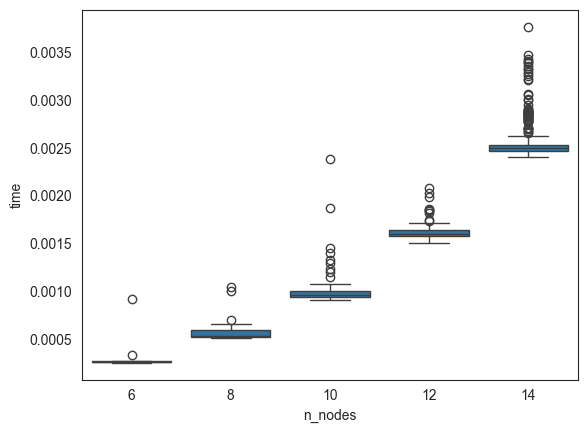

In [17]:
res_df['time-orig'] = res_df['time']
res_df['time'] = res_df['time'].clip(upper=0.01)
g = sns.boxplot(res_df, x='n_nodes', y='time')
g.get_figure().savefig("../output/fig/time_plot.eps", format='eps')

## Cumulative probability
For each size of the graph, draw the cumulative probability after each new tree is found. The quicker it reaches 1, the better.
If it plateaus, it means that new trees are rarely found.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


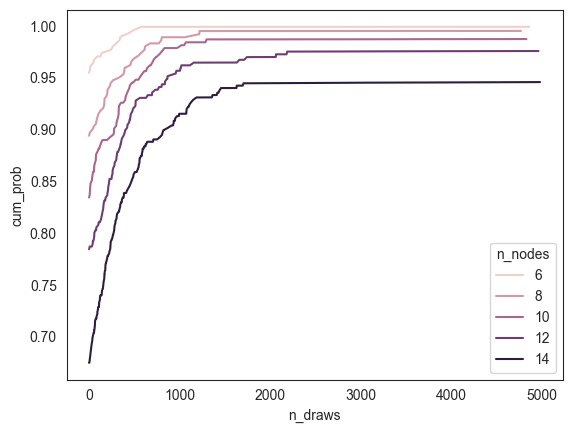

In [18]:
g = sns.lineplot(res_df, x='n_draws', y='cum_prob', hue='n_nodes')
g.get_figure().savefig("../output/fig/cumulative_plot.eps", format='eps')

## Residual probability analysis
Where it plateaus, the residual probability mass should be similar to the proportion of unseen trees that are sampled.
To determine a pleateau, we compute the increment in cumulative prob by the number of draws (increment ratio). And we fix a threshold for the incremental ratio.

[K=6 - after 432 draws] residual prob v. new tree rate: 0.007164106603796405 | 0.0018306636155606408
[K=8 - after 1467 draws] residual prob v. new tree rate: 0.004885387271042818 | 0.004081632653061225
[K=10 - after 1324 draws] residual prob v. new tree rate: 0.012920977171246406 | 0.01311806256306761
[K=12 - after 2224 draws] residual prob v. new tree rate: 0.024709236417392755 | 0.025858884373845585
[K=14 - after 1714 draws] residual prob v. new tree rate: 0.055314215365917296 | 0.05484068627450981


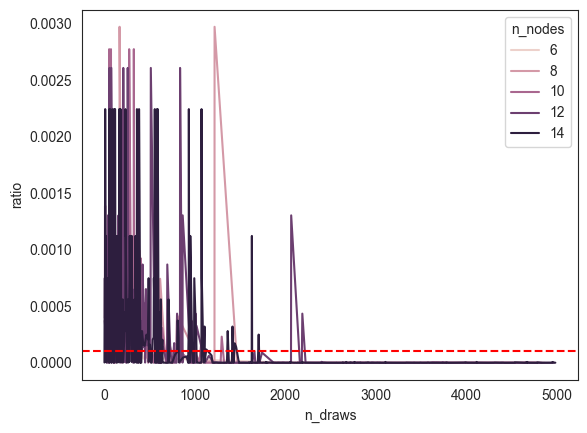

In [19]:
dyx = res_df.groupby(['n_nodes'])[['n_draws', 'cum_prob']].diff().fillna(0)
res_df['ratio'] = dyx['cum_prob'] / dyx['n_draws']
thresh = 0.0001
g = sns.lineplot(res_df, x='n_draws', y='ratio', hue='n_nodes')
g.axhline(thresh, color='red', linestyle='--')

res_df['thresh'] = (res_df['ratio'] < thresh).astype('int').diff().fillna(0)
elbows = res_df[res_df['thresh'] > 0].groupby('n_nodes').tail(1)[['n_nodes', 'n_draws', 'cum_prob']].values.tolist()

for n_nodes, n_draws, cum_prob in elbows:
    new_tree_rate = 1 / res_df[(res_df['n_nodes'] == int(n_nodes)) & (res_df['n_draws'] > n_draws)]['n_draws'].diff().fillna(0).mean()
    print(f'[K={int(n_nodes)} - after {int(n_draws)} draws] residual prob v. new tree rate: {1 - cum_prob} | {new_tree_rate}')



MAKE TEST: some trees are more difficult to sample than others, just based on the topology

In [20]:
res_df[res_df['n_nodes'] == 10]

,n_draws,cum_prob,tree_prob,acc_discovery,n_nodes,skew_factor,time,time-orig,ratio,thresh
74,0,0.834433,0.834433,1,10,300,0.000977,0.000977,NaN,-1.0
75,7,0.837205,0.002772,2,10,300,0.000944,0.000944,3.960289e-04,0.0
76,9,0.839977,0.002772,3,10,300,0.000977,0.000977,1.386101e-03,0.0
77,11,0.842749,0.002772,4,10,300,0.000947,0.000947,1.386101e-03,0.0
78,13,0.845522,0.002772,5,10,300,0.001234,0.001234,1.386101e-03,0.0
...,...,...,...,...,...,...,...,...,...,...
184,4651,0.987392,0.000009,111,10,300,0.000948,0.000948,4.604987e-06,0.0
185,4685,0.987401,0.000009,112,10,300,0.000999,0.000999,2.708816e-07,0.0
186,4697,0.987411,0.000009,113,10,300,0.000937,0.000937,7.674979e-07,0.0
187,4792,0.987420,0.000009,114,10,300,0.001455,0.001455,9.694710e-08,0.0


<Axes: >

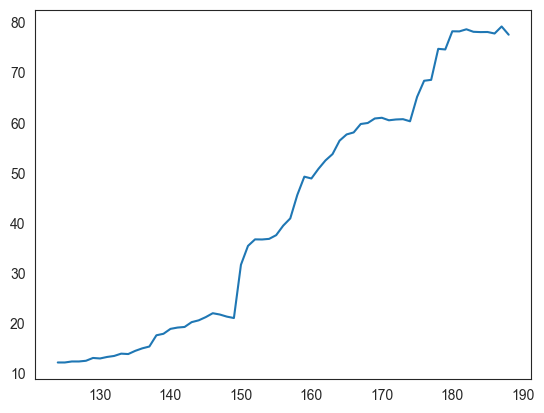

In [21]:
# plot rolling average of draws before a new unseen tree (every point on x is a new tree)
res_df[res_df['n_nodes'] == 10]['n_draws'].diff().rolling(window=50).mean().plot()

# Direction test
> test consistency of direction of arcs between W table and last-exit probabilities

In [22]:
# build graph with high probs in one direction and low in the opposite
# e.g. high prob for i->i+

n_nodes = 8
graph = nx.complete_graph(n_nodes, create_using=nx.DiGraph)
asc_mat = np.ones((n_nodes, n_nodes))
np.fill_diagonal(asc_mat, 0)
asc_mat += 299 * np.triu(asc_mat)
# asc_mat[5,:] = 0
graph = reset_adj_matrix(graph, matrix=asc_mat)
# graph = normalize_graph_weights(graph, rowwise=False)
print("Unbalanced graph:")
print(nx.to_numpy_array(graph))

ss = 1000
trees = []
for _ in range(ss):
    samp_tree = algorithms.random_spanning_tree(graph, root=0)
    trees.append(samp_tree)



Unbalanced graph:
[[  0. 300. 300. 300. 300. 300. 300. 300.]
 [  1.   0. 300. 300. 300. 300. 300. 300.]
 [  1.   1.   0. 300. 300. 300. 300. 300.]
 [  1.   1.   1.   0. 300. 300. 300. 300.]
 [  1.   1.   1.   1.   0. 300. 300. 300.]
 [  1.   1.   1.   1.   1.   0. 300. 300.]
 [  1.   1.   1.   1.   1.   1.   0. 300.]
 [  1.   1.   1.   1.   1.   1.   1.   0.]]


In [23]:
acc = 0
for t in trees:
    high_prob_arcs = sum([1 if u < v else 0 for u,v in t.edges()])
    print(f'{tree_to_newick(t)}: {graph_weight(t)} - {high_prob_arcs} / {n_nodes - 1}')
    acc += high_prob_arcs
print(f'avg {acc / len(trees)} high prob arcs')

(1,2,(5)3,((7)6)4)0: 0.00019122073530709017 - 7 / 7
(((7)3,(6)5)1,(4)2)0: 0.00019122073530709015 - 7 / 7
((4,5)1,(3,7)2,6)0: 0.00019122073530709015 - 7 / 7
((3,5)1,(4)2,(7)6)0: 0.00019122073530709015 - 7 / 7
((4)1,2,3,(6)5,7)0: 0.00019122073530709017 - 7 / 7
((2,7)1,(4,6)3,5)0: 0.00019122073530709017 - 7 / 7
(((7)2,(4,5)3)1,6)0: 0.00019122073530709012 - 7 / 7
((2,(4,7)3,(6)5)1)0: 0.00019122073530709015 - 7 / 7
((2,3,(7)4,6)1,5)0: 0.00019122073530709015 - 7 / 7
(((7)4,(6)5)1,(3)2)0: 0.00019122073530709017 - 7 / 7
(((4)2)1,3,(6)5,7)0: 0.00019122073530709017 - 7 / 7
(1,(3)2,(6)4,(7)5)0: 0.00019122073530709017 - 7 / 7
(((6)5)1,((4,7)3)2)0: 0.00019122073530709017 - 7 / 7
(((5)3)1,(7)2,4,6)0: 0.00019122073530709015 - 7 / 7
((7)1,(((6)5)3)2,4)0: 0.00019122073530709015 - 7 / 7
((6)1,2,((7)5)3,4)0: 0.00019122073530709017 - 7 / 7
((2,4,7)1,3,5,6)0: 0.00019122073530709017 - 7 / 7
(1,(3,(6)4)2,(7)5)0: 0.00019122073530709017 - 7 / 7
((7)1,((6)5)2,3,4)0: 0.00019122073530709017 - 7 / 7
((2,((7)4)3,6)